In [1]:
from music21 import converter, instrument, note, chord, stream
import tensorflow, numpy

In [2]:
def generate_input_data(song_path):

    notes = []
    midi = converter.parse(song_path)
    print("Parsing %s" % song_path)

    # use flat notes only
    notes_to_parse = midi.flat.notes

    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))

    sequence_length = 100

    # get all pitch names
    pitchnames = sorted(set(item for item in notes))

     # create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    network_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    n_vocab = len(set(notes))
    network_input = network_input / float(n_vocab)

    network_output = tensorflow.keras.utils.to_categorical(network_output)

    return network_input, network_output, pitchnames, n_vocab

In [3]:
def generate_sequence(model, network_input, pitchnames, n_vocab):

    # pick the last sequence from the input as a starting point for the prediction
    start = -1

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    prediction_output = []

    # generate 500 notes
    for note_index in range(500):
        prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        index = numpy.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)

        pattern = numpy.append(pattern, index)
        pattern = pattern[1:len(pattern)]

    return prediction_output

In [4]:
def create_midi(prediction_output):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp='test_output.mid')

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten

In [8]:
# Generate input data from MIDI file
network_input, network_output, pitchnames, n_vocab = generate_input_data('mozart.mid')

Parsing mozart.mid


In [11]:
# Define the LSTM model
model = Sequential([
    LSTM(512, input_shape=(network_input.shape[1], network_input.shape[2]), recurrent_dropout=0.3, return_sequences=True),
    LSTM(512, recurrent_dropout=0.3, return_sequences=True),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(95, activation='softmax')  # 95 should be replaced with n_vocab if the number of notes is different
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/100
10/10 [==============================] - 10s 488ms/step - loss: 4.5701 - accuracy: 0.0584
Epoch 2/100
10/10 [==============================] - 5s 497ms/step - loss: 3.7815 - accuracy: 0.0588
Epoch 3/100
10/10 [==============================] - 5s 466ms/step - loss: 3.6945 - accuracy: 0.0652
Epoch 4/100
10/10 [==============================] - 5s 485ms/step - loss: 3.6712 - accuracy: 0.0708
Epoch 5/100
10/10 [==============================] - 5s 484ms/step - loss: 3.6750 - accuracy: 0.0588
Epoch 6/100
10/10 [==============================] - 5s 489ms/step - loss: 3.6690 - accuracy: 0.0676
Epoch 7/100
10/10 [==============================] - 5s 502ms/step - loss: 3.6627 - accuracy: 0.0684
Epoch 8/100
10/10 [==============================] - 5s 481ms/step - loss: 3.6627 - accuracy: 0.0672
Epoch 9/100
10/10 [==============================] - 5s 492ms/step - loss: 3.6606 - accuracy: 0.0676
Epoch 10/100
10/10 [==============================] - 5s 486ms/step - loss: 3.6573 - accur

Text(0.5, 0, 'Epoch')

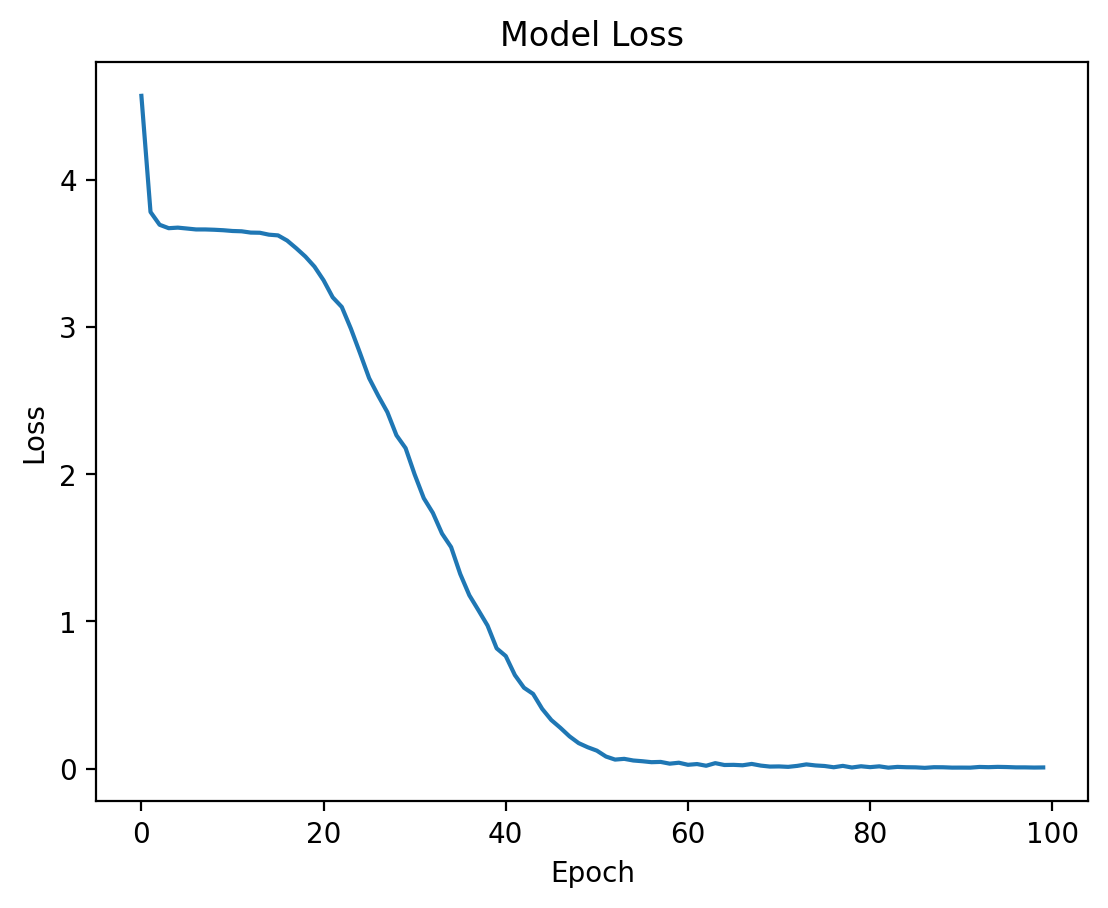

In [12]:
history = model.fit(network_input, network_output, epochs=100, batch_size=256)

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

The loss decreases quickly initially, indicating that the model is rapidly learning the main features of the dataset. This phase may corresponds to the model transitioning from random initialization to understanding underlying patterns in the data.

Around 4-20 epochs, the loss plateaus at approximately 3.6. The model may be transitting from learning simple patterns to comprehending more complex features. During this phase, improvement rate may slow down as the task becomes more challenging. Additionally, it could be due to adjustments made by the Adam optimizer in terms of learning rate during training.

Between 20 and 50 epochs, there is another drop in loss. This suggests that the network has started acquiring better representations of data, enabling more accurate sequence predictions and resulting in decreased loss. It could also be attributed to adjustments made by Adam optimizer regarding learning rate during training. When the learning rate might have been reduced, progress can be made by escaping local minima or saddle points for improved performance.

After 50 epochs, the model's loss continues to decrease and appears to converge at around a loss of 0.001. This suggests that the model has successfully learned the dataset's features and is no longer making further improvements.

In [13]:
# Generate a new music sequence
prediction_output = generate_sequence(model, network_input, pitchnames, n_vocab)

# Create a MIDI file from the generated sequence
create_midi(prediction_output)


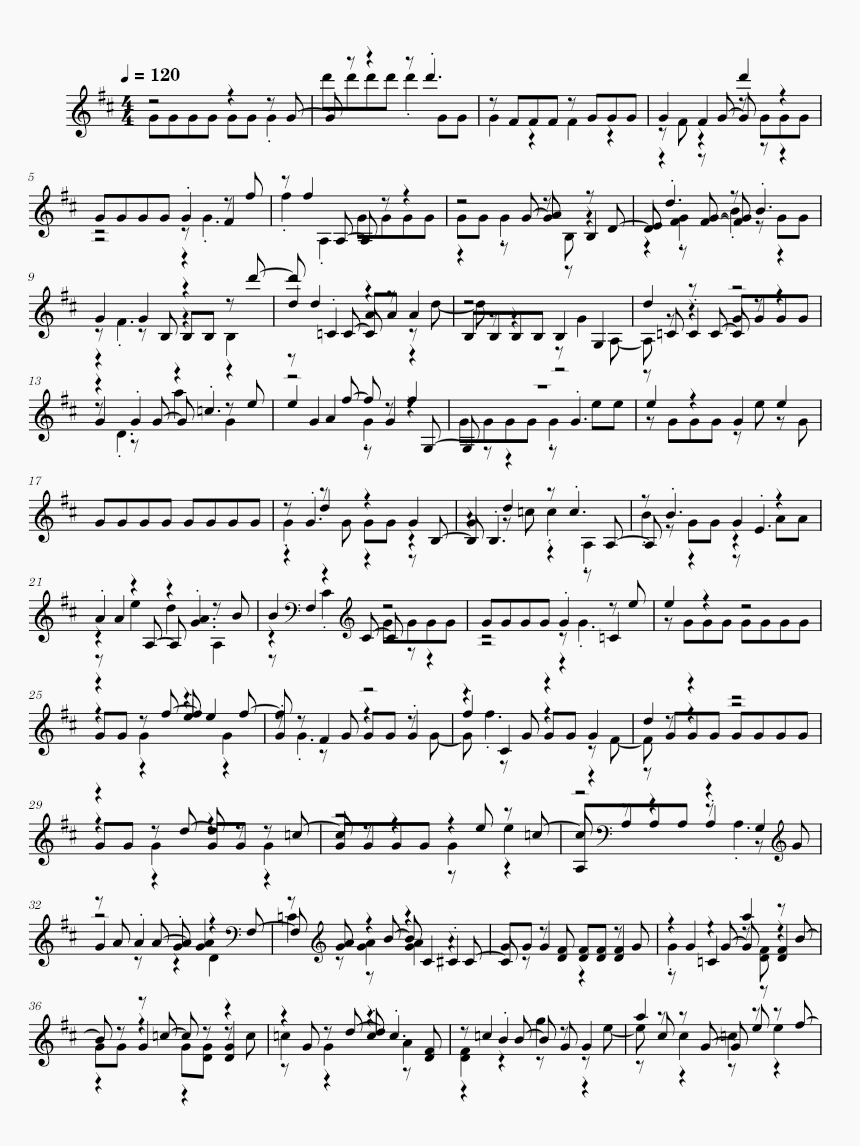

The model generates pieces of music that seem to make some sense but are not as good as Mozart's. This may be because the training data is insufficient and the model is not complex enough. For instance, the input data only considers flat notes and does not include other musical features like rhythm, key, tempo, etc. Consequently, the model cannot learn these music features effectively.

However, after several generations, I did find a decent piece of music. It is displayed below:

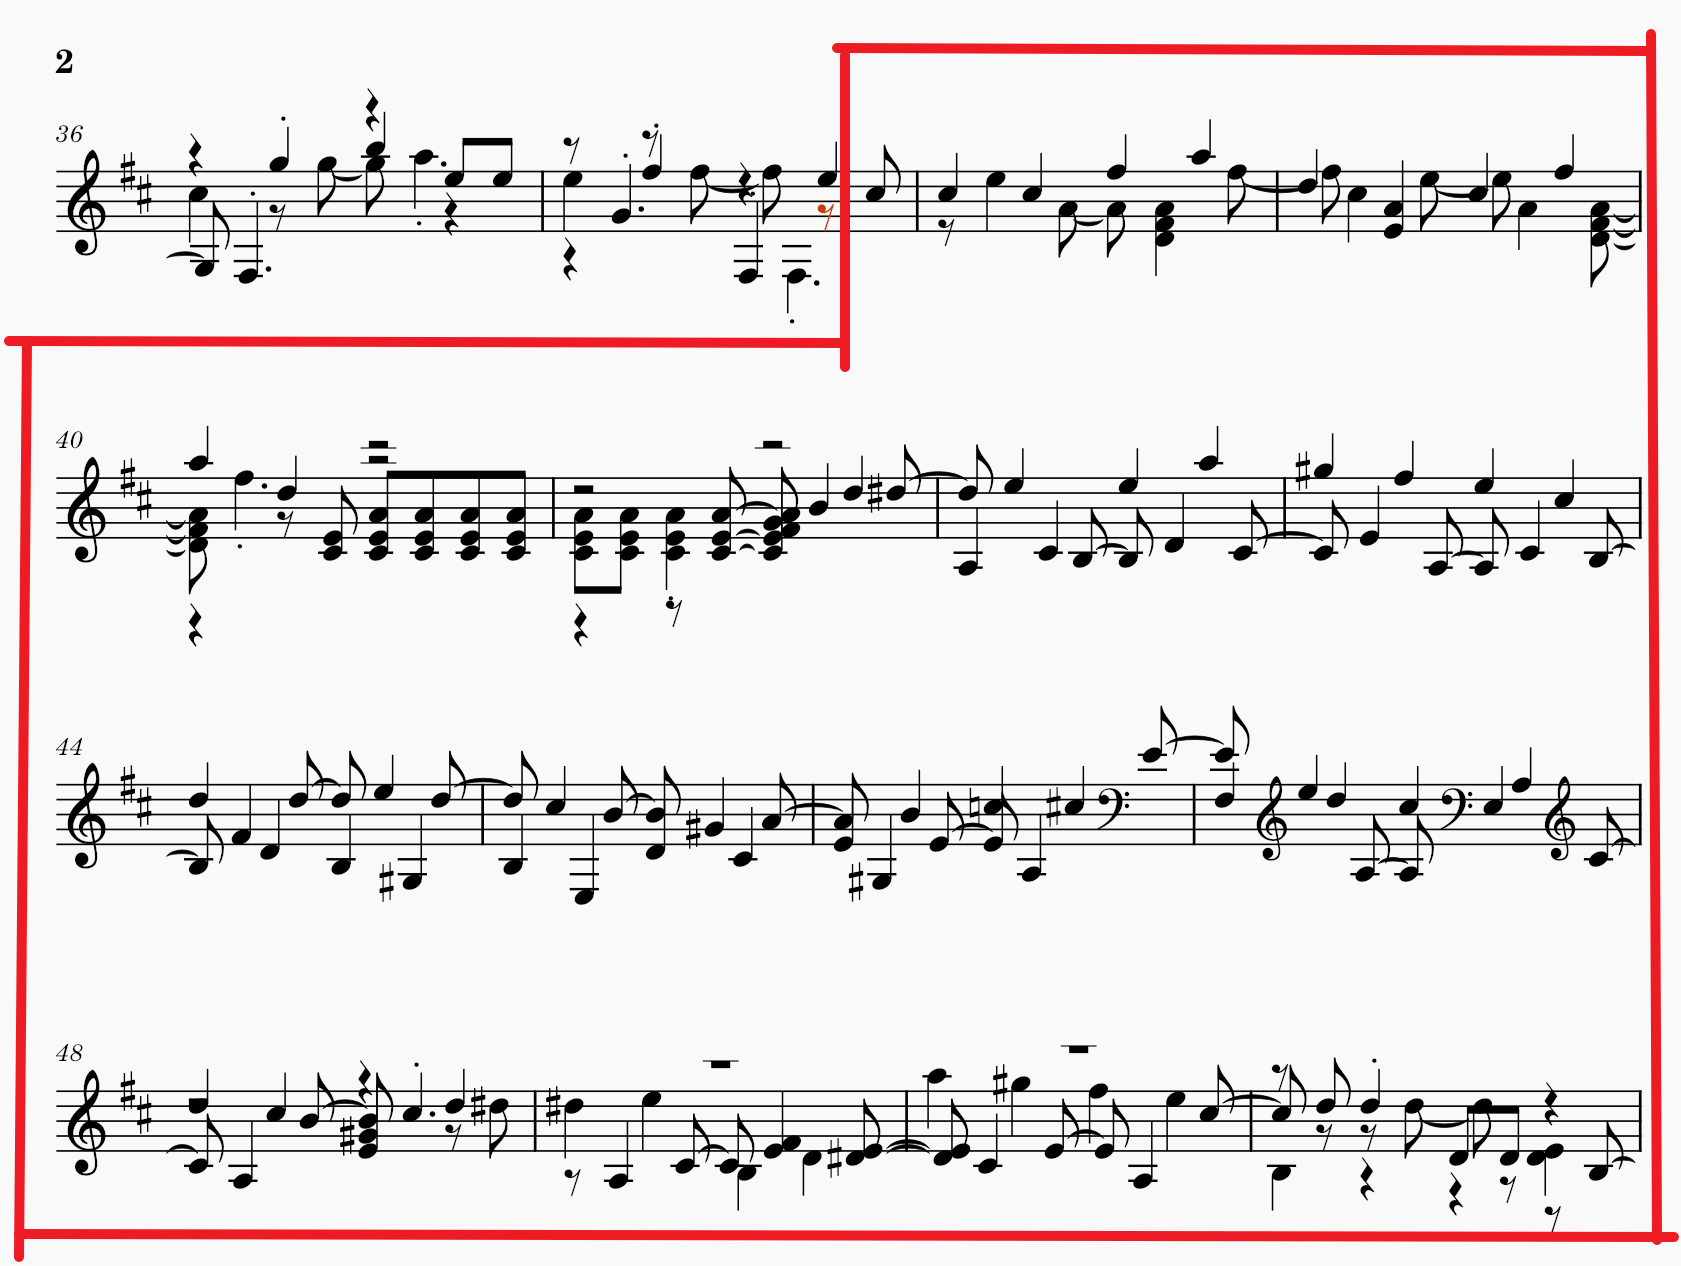

This section is quite elegant and may be 70% as good as Mozart's music. It doesn't exactly resemble Mozart's style, but it bears a strong resemblance to Bach's style, particularly his Well-Tempered Clavier. This is intriguing because we are aware that Mozart studied a lot of Bach's music in his youth. Perhaps this is why the model generated this type of music.